In [1397]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
from spacy import displacy
from spacy.language import Language
import pyLDAvis.gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.phrases import Phrases, Phraser
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import yake
import fasttext
import re

In [1464]:
# read csv
authors = pd.read_csv('input/top_20_authors.csv')
publications = pd.read_csv('input/publications-top_20_authors.csv', sep=',')

In [1398]:
authors = pd.read_csv('input/some_authors.csv')
publications = pd.read_csv('input/publications-some_authors.csv', sep=',')

In [1465]:
# make a dictionary containing the combined abstracts for each author
author_publication_pairs = list(zip(publications['user_id'], publications['abstract_text']))
texts = {author_id: [] for author_id in authors["id"]}

# load fastText model
model = fasttext.load_model('lid.176.bin')
for author_id, abstract in author_publication_pairs:
    if abstract and isinstance(abstract, str) and re.match('^(?=.*[a-zA-Z])', abstract):
        # predict the language
        predictions = model.predict(abstract)
        language = predictions[0][0].replace('__label__', '')
        # keep only texts written in English
        if language == 'en':
            texts[author_id].append(abstract)

In [1466]:
stop_words = ['abstract', 'al', 'amount', 'approach', 'article', 'available', 'base', 'based', 'benefit',
              'bucharest',
              'case', 'category', 'condition', 'conference', 'context', 'copyright', 'datum', 'demonstrate',
              'demonstrates', 'demonstrated',
              'different', 'difficult', 'et', 'experiment', 'experimental', 'faculty', 'helpful', 'high',
              'ieee', 'importance', 'important', 'inconvenience', 'interest', 'interested', 'interests', 'jat',
              'jats', 'laboratory',
              'main', 'multiple', 'new', 'obtain', 'obtained', 'obtains', 'old', 'order', 'organization', 'paper',
              'people', 'policy', 'politehnica', 'polytechnic',
              'present', 'presents', 'presented', 'privacy', 'professor', 'propose', 'proposes', 'proposed',
              'quality', 'range', 'ranges', 'real',
              'recent', 'research', 'researcher', 'result', 'scale', 'show', 'shows', 'showed', 'student', 'study',
              'subject', 'studies', 'studied', 'task',
              'teacher', 'term', 'text', 'title', 'type', 'unavailable', 'university', 'useful',
              'workshop']

EXTRACT KEYWORDS/KEYPHRASES WITH YAKE

In [1467]:
nlp = spacy.load('en_core_web_lg', exclude=['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])

In [1529]:
abstract_list = texts[872]

In [1530]:
# remove abstracts that contain mostly person and organization names
clean_abstract_list = []

for abstract in abstract_list:
    nlp.max_length = len(abstract) + 1000
    doc = nlp(abstract)
    person_orgs_count = 0
    other_words_count = 0

    for token in doc:
        if token.ent_type_ == 'PERSON' or token.ent_type_ == 'ORG':
            person_orgs_count += 1
        elif token.is_alpha:
            other_words_count += 1

    if person_orgs_count < other_words_count:
        clean_abstract_list.append(abstract)

In [1531]:
# concatenate the abstracts into a single string
text = '\n'.join(clean_abstract_list)

In [1532]:
from time import perf_counter

In [1533]:
# remove some named entities
t1_start = perf_counter()
nlp.max_length = len(text) + 1000
doc = nlp(text)
remove_entities = ['PERSON', 'NORP', 'FAC', 'GPE', 'LOC', 'DATE', 'TIME', 'PERCENT', 'MONEY',
                   'QUANTITY', 'CARDINAL', 'ORDINAL']

transformed_text = ' '.join([token.text for token in doc if token.ent_type_ not in remove_entities])
t1_stop = perf_counter()
print(t1_stop - t1_start)

7.589088700013235


In [1534]:
# set parameters for yake keyword extractor
max_ngram = 3
deduplication_threshold = 0.5
keywords_nr = 15
windows_size = 1

kw_extractor = yake.KeywordExtractor(lan="en", n=max_ngram, dedupLim=deduplication_threshold,
                                     top=keywords_nr, windowsSize=windows_size)
# add custom stop words to the default set from yake
kw_extractor.stopword_set.update(set(stop_words))

# extract keywords
keywords = kw_extractor.extract_keywords(transformed_text)
for kw, _ in keywords:
    print(kw)

wireless sensor networks
neural networks
system
process control systems
sensor network systems
image processing system
Unmanned Aerial Vehicles
convolutional neural network
images
network
control
data
system architecture
multi WSN network
fractal dimension


In [1535]:
print(len(doc.ents))
# print(doc.ents)
for tok in doc:
    if tok.ent_type_ == "ORG":
        print(tok.text + " " + tok.ent_type_)

1601
Adiabatic ORG
EFD ORG
FD ORG
EFD ORG
FD ORG
Pitesti ORG
University ORG
POLITEHNICA ORG
UPB ORG
TTO ORG
UPB ORG
CDU ORG
DCU ORG
CDU ORG
Conference ORG
, ORG
Process ORG
Integration ORG
P7.72 ORG
DCU ORG
UAV ORG
SCADA ORG
a ORG
Regional ORG
Control ORG
Center ORG
Photogrammetry ORG
an ORG
Unmanned ORG
Aerial ORG
System ORG
UAS ORG
UAS ORG
Ehrhart ORG
UAV ORG
Generative ORG
Adversarial ORG
Networks ORG
GAN ORG
Graphics ORG
Processing ORG
Units ORG
GPU ORG
GAN ORG
GDTs ORG
UAV ORG
DATCOM ORG
Digital ORG
DNW ORG
FD ORG
LTR ORG
Takagi ORG
- ORG
Sugeno ORG
Linear ORG
Matrix ORG
Inequality ORG
Subspace ORG
State ORG
Space ORG
System ORG
Identification ORG
LS ORG
IDEOPT ORG
PIM ORG
Autodesk ORG
Inventor ORG
Professional ORG
2009 ORG
for ORG
Recycled ORG
Silicone ORG
Rubber ORG
Atomic ORG
Force ORG
Microscopy ORG
The ORG
Dynamic ORG
Mechanical ORG
Analysis ORG
the ORG
Stress ORG
Analysis ORG
Modeling ORG
EMA ORG
Cyclammina ORG
Nyquist ORG
Integrated ORG
Management ORG
System ORG
Quality ORG

In [1536]:
org_count = 0
for ent in doc.ents:
    if ent.label_ == 'ORG':
        print(ent.text + ' ' + ent.label_)
        org_count += 1

Adiabatic ORG
EFD ORG
FD ORG
EFD ORG
FD ORG
Pitesti ORG
University POLITEHNICA ORG
UPB ORG
TTO ORG
UPB ORG
CDU ORG
DCU ORG
CDU ORG
Conference, Process Integration ORG
P7.72 ORG
DCU ORG
UAV ORG
SCADA ORG
a Regional Control Center ORG
Photogrammetry ORG
an Unmanned Aerial System ORG
UAS ORG
UAS ORG
Ehrhart ORG
UAV ORG
Generative Adversarial Networks ORG
GAN ORG
Graphics Processing Units ORG
GPU ORG
GAN ORG
GDTs ORG
UAV ORG
DATCOM ORG
Digital ORG
DNW ORG
FD ORG
LTR ORG
Takagi-Sugeno ORG
Linear Matrix Inequality ORG
Subspace ORG
State Space System Identification ORG
LS ORG
IDEOPT ORG
PIM ORG
Autodesk Inventor Professional 2009 for Recycled Silicone Rubber ORG
Atomic Force Microscopy ORG
The Dynamic Mechanical Analysis ORG
the Stress Analysis Modeling ORG
EMA ORG
Cyclammina ORG
Nyquist ORG
Integrated Management System Quality-Environmental-Occupational Health and Safety ORG
W-Cu-Ni ORG
deviceholder ORG
Hurwitz ORG
Wireless ORG
ROV ORG
femtocell ORG
femtocell ORG
IRIS ORG
Wireless Sensor Net

In [1537]:
print(org_count)

532


In [1538]:
for ent in doc.ents:
    if ent.label_ == 'ORG' and ('Big Data' in ent.text or 'Cloud' in ent.text):
        print(ent.text + ' ' + ent.label_)

Big Datas ORG


In [1539]:
displacy.render(doc, style="ent")

c:\users\ana_maria.nastase\appdata\local\programs\python\python39\lib\site-packages\spacy\displacy\__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [1540]:
from termcolor import colored

# Funcție pentru evidențierea cuvintelor cheie
def highlight_keywords(text, keywords):
    for kw, _ in keywords:
        text = text.replace(kw, colored(kw, 'red', attrs=['bold']))
    return text

# Evidențierea cuvintelor cheie în text
highlighted_text = highlight_keywords(text, keywords)
print(highlighted_text)

Objectives: Prescribing, dosing and delivering chemotherapy to the cancer patients is a complex, highly specialized and time consuming process, requiring a specialized team (medical oncology clinician or veterinarian, nurse, pharmacist). Our aim was to create a software that fills the gap between medical doctors, pharmacists and nurses and consequently speeds up the calculation, dosing and preparation of chemotherapy and biological (targeted) therapy in medical oncology. Dedicated versions for human and veterinary medicine are available. Results: First version (chemotherapy and hormonal therapy in humans) was created in 1997 and the software was continuously updated. The 2014 update includes four versions (ie for humans or pets and standalone or network). The protocol library was extended to more than 800 chemotherapy protocols to include new chapters such as molecular targeted therapy and
This study examined the effect of hexane concentration in the inlet gas stream on the treatment p

EXTRACT KEYWORDS WITH LDA

In [1541]:
abstract_list = texts[872]

In [1542]:
nlp = spacy.load('en_core_web_lg')

In [1543]:
# remove abstracts that contain mostly person and organization names
clean_abstract_list = []

for abstract in abstract_list:
    nlp.max_length = len(abstract) + 1000
    doc = nlp(abstract)
    person_orgs_count = 0
    other_words_count = 0

    for token in doc:
        if token.ent_type_ == 'PERSON' or token.ent_type_ == 'ORG':
            person_orgs_count += 1
        elif token.is_alpha:
            other_words_count += 1

    if person_orgs_count < other_words_count:
        clean_abstract_list.append(abstract)

In [1544]:
# keep only adjectives and nouns
remove_pos = ['ADV', 'PRON', 'PART', 'DET', 'SPACE', 'NUM', 'SYM', 'ADP', 'VERB', 'CCONJ', 'INTJ']
remove_entities = ['PERSON', 'NORP', 'FAC', 'GPE', 'LOC', 'LANGUAGE', 'DATE', 'TIME', 'PERCENT', 'MONEY',
                   'QUANTITY', 'CARDINAL', 'ORDINAL']

tokens = []
for abstract in clean_abstract_list:
    nlp.max_length = len(abstract) + 1000
    doc = nlp(abstract)
    t = [token.lemma_.upper() for token in doc if token.is_alpha and token.ent_type_ not in remove_entities
                             and token.lemma_.lower() not in stop_words and token.pos_ not in remove_pos and not token.is_stop]
    tokens.append(t)

# add bigrams to the token list
bigram = Phrases(tokens, min_count=3, delimiter=' ', threshold=1)
tokens = [bigram[text] for text in tokens]
trigram = Phrases(tokens, min_count=3, delimiter=' ', threshold=1)
tokens = [trigram[text] for text in tokens]

In [1545]:
# remove single words
ngrams = [[token for token in text if len(token.split(" ")) > 1] for text in tokens]

In [1546]:
word_count = 0
for text in ngrams:
    word_count += len(text)

if word_count > 100:
    tokens = ngrams

In [1547]:
print(word_count)

2490


In [1548]:
# create dictionary with gensim
dictionary = Dictionary(tokens)
# create corpus
corpus = [dictionary.doc2bow(text) for text in tokens]

In [1549]:
# apply LDA
num_topics = 1
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=1, num_topics=num_topics, workers=3, passes=1)

In [1550]:
for i in range(num_topics):
    words = [word for word, _ in topics]

    for w in words:
        print(w)
        
    print()

CLOUD COMPUTING
SCHEDULING ALGORITHM
RESOURCE MANAGEMENT
BIG DATA
SMART CITY
TIME SERIES
CLOUD SYSTEM
SATELLITE IMAGE
FAULT TOLERANCE
LARGE SYSTEM
WEB SERVICE
GENETIC ALGORITHM
RESOURCE UTILIZATION
SMART ENVIRONMENT
COMPLEX SYSTEM



In [1551]:
cm = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v', topn=15)
coherence = cm.get_coherence()
print(coherence)

0.47967017959957375


In [1492]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

OSError: [Errno 22] Invalid argument

CREATE WORDCLOUD

In [1552]:
from wordcloud import WordCloud

In [1553]:
topics = lda_model.show_topic(topicid=0, topn=15)
lda_kw_dict = {word: prob * 100 for word, prob in topics}
print(lda_kw_dict)

{'NEURAL NETWORK': 2.2486962378025055, 'SENSOR NETWORK': 0.9880662895739079, 'WIRELESS SENSOR NETWORK': 0.9539962746202946, 'FRACTAL DIMENSION': 0.919925794005394, 'IMAGE PROCESSING': 0.817714910954237, 'CONVOLUTIONAL NEURAL NETWORK': 0.715499883517623, 'ENERGY CONSUMPTION': 0.7154971826821566, 'CONTROL SYSTEM': 0.6814281456172466, 'ARTIFICIAL INTELLIGENCE': 0.6814281456172466, 'TEXTURE CLASSIFICATION': 0.6473540794104338, 'UNMANNED AERIAL VEHICLE UAV': 0.6132897920906544, 'LEARNING PHASE': 0.5792147479951382, 'RETINAL IMAGE': 0.5792143288999796, 'SYSTEM ARCHITECTURE': 0.5792139563709497, 'POINT VIEW': 0.5792108830064535}


In [1554]:
yake_kw_dict = {word.upper(): score * 100000 for word, score in keywords}
print(yake_kw_dict)

{'WIRELESS SENSOR NETWORKS': 2.3684186597722023, 'NEURAL NETWORKS': 16.975800960767852, 'SYSTEM': 17.620183066842163, 'PROCESS CONTROL SYSTEMS': 18.833088015898646, 'SENSOR NETWORK SYSTEMS': 27.94549364271916, 'IMAGE PROCESSING SYSTEM': 28.6899708692128, 'UNMANNED AERIAL VEHICLES': 29.08891591252691, 'CONVOLUTIONAL NEURAL NETWORK': 31.67610837236031, 'IMAGES': 31.773425881562225, 'NETWORK': 32.96305181438747, 'CONTROL': 36.46871059019117, 'DATA': 49.05119993306043, 'SYSTEM ARCHITECTURE': 53.079518352365085, 'MULTI WSN NETWORK': 57.208887759328114, 'FRACTAL DIMENSION': 60.45948606522443}


In [1555]:
yake_kw_dict = {word_yake: lda_kw_dict[word_lda] for word_lda, word_yake in zip(lda_kw_dict, yake_kw_dict)}
print(yake_kw_dict)

{'WIRELESS SENSOR NETWORKS': 2.2486962378025055, 'NEURAL NETWORKS': 0.9880662895739079, 'SYSTEM': 0.9539962746202946, 'PROCESS CONTROL SYSTEMS': 0.919925794005394, 'SENSOR NETWORK SYSTEMS': 0.817714910954237, 'IMAGE PROCESSING SYSTEM': 0.715499883517623, 'UNMANNED AERIAL VEHICLES': 0.7154971826821566, 'CONVOLUTIONAL NEURAL NETWORK': 0.6814281456172466, 'IMAGES': 0.6814281456172466, 'NETWORK': 0.6473540794104338, 'CONTROL': 0.6132897920906544, 'DATA': 0.5792147479951382, 'SYSTEM ARCHITECTURE': 0.5792143288999796, 'MULTI WSN NETWORK': 0.5792139563709497, 'FRACTAL DIMENSION': 0.5792108830064535}


In [1556]:
combined_dict = lda_kw_dict.copy()
combined_dict.update(yake_kw_dict)
print(combined_dict)

{'NEURAL NETWORK': 2.2486962378025055, 'SENSOR NETWORK': 0.9880662895739079, 'WIRELESS SENSOR NETWORK': 0.9539962746202946, 'FRACTAL DIMENSION': 0.5792108830064535, 'IMAGE PROCESSING': 0.817714910954237, 'CONVOLUTIONAL NEURAL NETWORK': 0.6814281456172466, 'ENERGY CONSUMPTION': 0.7154971826821566, 'CONTROL SYSTEM': 0.6814281456172466, 'ARTIFICIAL INTELLIGENCE': 0.6814281456172466, 'TEXTURE CLASSIFICATION': 0.6473540794104338, 'UNMANNED AERIAL VEHICLE UAV': 0.6132897920906544, 'LEARNING PHASE': 0.5792147479951382, 'RETINAL IMAGE': 0.5792143288999796, 'SYSTEM ARCHITECTURE': 0.5792143288999796, 'POINT VIEW': 0.5792108830064535, 'WIRELESS SENSOR NETWORKS': 2.2486962378025055, 'NEURAL NETWORKS': 0.9880662895739079, 'SYSTEM': 0.9539962746202946, 'PROCESS CONTROL SYSTEMS': 0.919925794005394, 'SENSOR NETWORK SYSTEMS': 0.817714910954237, 'IMAGE PROCESSING SYSTEM': 0.715499883517623, 'UNMANNED AERIAL VEHICLES': 0.7154971826821566, 'IMAGES': 0.6814281456172466, 'NETWORK': 0.6473540794104338, 'CONT

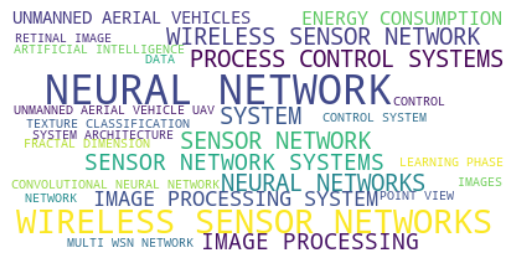

In [1557]:
wordcloud = WordCloud(background_color='white')

wordcloud.generate_from_frequencies(combined_dict)
wordcloud.to_file('pictures/wordcloud_popescu.png')

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()